In [1]:
# SETUP AND IMPORTS
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
import sys
import os
import random

# --- PyTorch and Sklearn Imports --
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score
from tqdm.notebook import tqdm

# --- TensorFlow for Data Loading ONLY --
import tensorflow as tf

# --- CRITICAL FIX: Isolate TensorFlow to CPU to avoid conflicts with PyTorch ---
try:
    physical_devices = tf.config.list_physical_devices()
    cpus = [d for d in physical_devices if d.device_type == 'CPU']
    tf.config.set_visible_devices(cpus)
    print("✅ TensorFlow successfully configured to use CPU only.")
    if not tf.config.list_physical_devices('GPU'):
        print("   - Confirmed: TensorFlow does not see the GPU.")
    if torch.cuda.is_available():
        print(f"✅ PyTorch can see and use the GPU: {torch.cuda.get_device_name(0)}")
except Exception as e:
    print(f"An error occurred during device configuration: {e}")

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define data directory
# Ensure this path is correct for your environment
DATA_DIR = Path("/kaggle/input/modified-next-day-wildfire-spread/ndws_western_dataset")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📂 Directory exists: {DATA_DIR.exists()}")

# --- CORRECTED TFRecord PARSING FUNCTION --
def parse_tfrecord_flexible(example):
    """
    Parse TFRecord with the CORRECT feature description.
    """
    feature_description = {}
    expected_features = [
        'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
        'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
        'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
        'fuel1', 'fuel2', 'fuel3', 'viirs_PrevFireMask', 'viirs_FireMask'
    ]
    for feat in expected_features:
        feature_description[feat] = tf.io.FixedLenFeature([64, 64], tf.float32)
    
    parsed_features = tf.io.parse_single_example(example, feature_description)
    return parsed_features

print("\n✅ Setup complete!")

2025-10-10 18:50:28.869636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760122228.891992     127 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760122228.898921     127 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ TensorFlow successfully configured to use CPU only.
✅ PyTorch can see and use the GPU: Tesla P100-PCIE-16GB
📁 Data directory: /kaggle/input/modified-next-day-wildfire-spread/ndws_western_dataset
📂 Directory exists: True

✅ Setup complete!


In [2]:
# VISUALIZATION FUNCTIONS (PYTORCH VERSION)
def visualize_fire_predictions_pytorch(model, X_test, y_test, num_samples=4):
    """Visualize fire prediction results from a PyTorch model"""
    if len(X_test) == 0:
        print("❌ No test samples available for visualization")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    X_test_subset = X_test[:num_samples]
    y_test_subset = y_test[:num_samples]
    
    with torch.no_grad():
        # Transpose from (N, H, W, C) to (N, C, H, W) for PyTorch
        X_test_tensor = torch.from_numpy(np.transpose(X_test_subset, (0, 3, 1, 2))).float().to(device)
        predictions_tensor = model(X_test_tensor)
        # Transpose back to (N, H, W, C) for visualization
        predictions = np.transpose(predictions_tensor.cpu().numpy(), (0, 2, 3, 1))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # The first channel of the input is the 'viirs_PrevFireMask'
        input_fire = X_test_subset[i, :, :, 0]
        true_fire = y_test_subset[i, :, :, 0]
        pred_fire = predictions[i, :, :, 0]

        axes[i, 0].imshow(input_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Sample {i+1}: Input Fire (t)')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 1].set_title(f'True Fire (t+1)')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 2].set_title(f'Predicted Fire (t+1)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\n📊 PREDICTION STATISTICS:")
    print(f"🔥 True fire pixels in displayed samples: {np.sum(y_test_subset > 0.1)}")
    print(f"🎯 Predicted fire pixels (threshold > 0.5): {np.sum(predictions > 0.5)}")
    print(f"📈 Average prediction confidence: {np.mean(predictions):.4f}")

# 🔥 SPATIAL FIRE SPREAD PREDICTION WITH U-NET ARCHITECTURE

**CRITICAL FIX**: This section implements proper spatial fire spread prediction using:
- ✅ **Raw spatial features** (64x64 grids) - NOT statistical summaries
- ✅ **All 23 environmental features** as spatial inputs
- ✅ **U-Net architecture** for pixel-level fire spread prediction
- ✅ **Temporal prediction**: PrevFireMask(t) → FireMask(t+1)
- ✅ **Research-based approach** following wildfire prediction literature

**Key Point**: The engineered features above are for EDA/visualization only. All prediction uses RAW SPATIAL DATA.

In [3]:
# --- CUSTOM PYTORCH DATASET FOR EFFICIENT MEMORY USAGE ---
class WildfireDataset(Dataset):
    """
    PyTorch Dataset for loading wildfire sequences "just-in-time" from TFRecords.
    This avoids loading the entire dataset into memory.
    """
    def __init__(self, data_dir, num_timesteps=4, max_sequences=None, normalization_stats=None):
        self.data_dir = data_dir
        self.num_timesteps = num_timesteps
        self.normalization_stats = normalization_stats
        self.sequence_len = self.num_timesteps + 2 # Total daily records needed for one sequence

        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population', 'impervious', 'water',
            'tmp_day', 'tmp_75', 'wind_avg', 'wind_75', 'wdir_wind', 'wdir_gust', 'gust_med',
            'avg_sph', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3'
        ]

        print("🔥 Initializing WildfireDataset: Building sequence index...")
        self.tfrecord_files = sorted(list(self.data_dir.glob("*.tfrecord")))
        self.index = self._build_index()

        if max_sequences is not None and max_sequences < len(self.index):
            print(f" M Randomly sampling {max_sequences} sequences from the full dataset.")
            self.index = random.sample(self.index, max_sequences)

        print(f"✅ Index created. Dataset contains {len(self.index)} sequences.")

    def _build_index(self):
        """ Scans TFRecords and creates a master list of all valid sequence start points. """
        index = []
        for file_path in self.tfrecord_files:
            num_records = sum(1 for _ in tf.data.TFRecordDataset(str(file_path)))
            for i in range(num_records - self.sequence_len + 1):
                index.append((str(file_path), i)) # Store (filepath, record_offset)
        return index

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        """ Loads and processes a single sequence from disk on demand. """
        file_path, record_offset = self.index[idx]
        dataset = tf.data.TFRecordDataset(file_path)
        raw_records = dataset.skip(record_offset).take(self.sequence_len)
        
        daily_samples = []
        for raw_record in raw_records:
            parsed_sample = parse_tfrecord_flexible(raw_record)
            sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
            daily_samples.append(sample_data)

        past_environmental_sequence = daily_samples[0 : self.num_timesteps]
        current_day_sample = daily_samples[self.num_timesteps]
        next_day_sample = daily_samples[self.num_timesteps + 1]

        input_features = []
        input_features.append(current_day_sample['viirs_PrevFireMask'].reshape(64, 64, 1))
        for past_sample in past_environmental_sequence:
            for feature_name in self.environmental_features:
                if feature_name in past_sample:
                    input_features.append(past_sample[feature_name].reshape(64, 64, 1))
        for feature_name in self.environmental_features:
             if feature_name in current_day_sample:
                input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))

        x = np.concatenate(input_features, axis=2).astype(np.float32)
        x = np.transpose(x, (2, 0, 1))

        y = next_day_sample['viirs_FireMask'].reshape(64, 64, 1).astype(np.float32)
        y = (np.transpose(y, (2, 0, 1)) > 0.1).astype(np.float32)

        x_tensor = torch.from_numpy(x)
        y_tensor = torch.from_numpy(y)

        if self.normalization_stats is not None:
            means = self.normalization_stats['means']
            stds = self.normalization_stats['stds']
            x_tensor = (x_tensor - means) / stds

        return x_tensor, y_tensor

def calculate_normalization_stats(dataset, num_samples=500):
    """ Calculates mean and std for normalization on a subset of the data. """
    print(f"📊 Calculating normalization statistics on {num_samples} random samples...")
    num_samples = min(num_samples, len(dataset))
    sampler = SubsetRandomSampler(random.sample(range(len(dataset)), num_samples))
    loader = DataLoader(dataset, batch_size=16, sampler=sampler, num_workers=2)

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for inputs, _ in tqdm(loader, desc="Calculating Stats"):
        channels_sum += torch.mean(inputs, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(inputs**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    std[std == 0] = 1 # Avoid division by zero
    
    stats = {'means': mean.reshape(-1, 1, 1), 'stds': std.reshape(-1, 1, 1)}
    print("✅ Normalization stats calculated.")
    return stats

In [4]:
# --- PYTORCH UNET ARCHITECTURE & REFACTORED TRAINING FUNCTION ---

# 1. LOSS FUNCTION: BCE + Dice
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets, smooth=1e-6):
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        
        bce_loss = nn.BCELoss()(inputs_flat, targets_flat)
        
        intersection = (inputs_flat * targets_flat).sum()
        dice_score = (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        dice_loss = 1 - dice_score
        
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

# 2. U-NET MODEL DEFINITION (Retained from Original 03-unet.ipynb)
class FireUNetPyTorch(nn.Module):
    def __init__(self, in_channels, out_channels, filters_base=32):
        super(FireUNetPyTorch, self).__init__()
        def _conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=False), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1, bias=False), nn.ReLU(inplace=True))
        
        self.enc1 = _conv_block(in_channels, filters_base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = _conv_block(filters_base, filters_base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = _conv_block(filters_base*2, filters_base*4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = _conv_block(filters_base*4, filters_base*8)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = _conv_block(filters_base*8, filters_base*16)
        self.upconv4 = nn.ConvTranspose2d(filters_base*16, filters_base*8, 2, stride=2)
        self.dec4 = _conv_block(filters_base*16, filters_base*8)
        self.upconv3 = nn.ConvTranspose2d(filters_base*8, filters_base*4, 2, stride=2)
        self.dec3 = _conv_block(filters_base*8, filters_base*4)
        self.upconv2 = nn.ConvTranspose2d(filters_base*4, filters_base*2, 2, stride=2)
        self.dec2 = _conv_block(filters_base*4, filters_base*2)
        self.upconv1 = nn.ConvTranspose2d(filters_base*2, filters_base, 2, stride=2)
        self.dec1 = _conv_block(filters_base*2, filters_base)
        self.out_conv = nn.Conv2d(filters_base, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.dec4(torch.cat([self.upconv4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))
        return torch.sigmoid(self.out_conv(d1))

# 3. ADVANCED TRAINING FUNCTION with Checkpointing
def train_fire_unet_cv_pytorch(dataset, n_splits=5, epochs=20, batch_size=4, checkpoint_path="unet_checkpoint.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_gpu = torch.cuda.is_available()
    print(f"🚀 INITIATING TRAINING ON {device} WITH {n_splits}-FOLD CV")
    print(f"🎯 Main Metric: Average Precision (AP)")
    print("=" * 60)

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_ap_scores = []
    last_model = None
    start_fold = 0
    checkpoint = None

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        start_fold = checkpoint['fold']
        if checkpoint['epoch'] == epochs - 1: start_fold += 1
        fold_ap_scores = checkpoint.get('fold_ap_scores', [])
        print(f"🔄 Resuming training from fold {start_fold}")

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        if fold < start_fold: continue

        print(f"\n========== FOLD {fold + 1}/{n_splits} ==========")
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2, pin_memory=use_gpu)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2, pin_memory=use_gpu)

        sample_x, _ = dataset[0]
        model = FireUNetPyTorch(in_channels=sample_x.shape[0], out_channels=1).to(device)
        criterion = BCEDiceLoss(weight=0.2)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        start_epoch = 0
        if checkpoint is not None and fold == checkpoint['fold'] and checkpoint['epoch'] < epochs - 1:
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"🔄 Resuming fold {fold+1} from epoch {start_epoch}")

        print(f"🔥 STARTING TRAINING...")
        for epoch in range(start_epoch, epochs):
            model.train()
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                progress_bar.set_postfix(loss=f"{loss.item():.4f}")
            
            # Save checkpoint after each epoch
            torch.save({
                'fold': fold, 'epoch': epoch, 'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(), 'fold_ap_scores': fold_ap_scores
            }, checkpoint_path)

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                all_preds.append(outputs.cpu().numpy().flatten())
                all_labels.append(labels.cpu().numpy().flatten())

        ap_score = average_precision_score(np.concatenate(all_labels), np.concatenate(all_preds))
        if len(fold_ap_scores) == fold:
            fold_ap_scores.append(ap_score)
        print(f"✅ Fold {fold + 1} Validation - AP: {ap_score:.4f}")
        last_model = model

    print("\n\n📊 CROSS-VALIDATION SUMMARY"); print("=" * 60)
    if fold_ap_scores:
        print(f"  - Mean AP ± Std Dev: {np.mean(fold_ap_scores):.4f} ± {np.std(fold_ap_scores):.4f}")
    if last_model:
        model_save_path = "final_unet_model.pth"
        torch.save(last_model.state_dict(), model_save_path)
        print(f"\n💾 Final model from last fold saved to '{model_save_path}'")
        if os.path.exists(checkpoint_path):
            os.remove(checkpoint_path)
            print(f"🗑️ Removed temporary checkpoint file: '{checkpoint_path}'")

    return last_model, fold_ap_scores

--- Step 1: Preparing Dataset ---
🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 100 sequences from the full dataset.
✅ Index created. Dataset contains 100 sequences.
📊 Calculating normalization statistics on 100 random samples...


Calculating Stats:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Normalization stats calculated.
🔥 Initializing WildfireDataset: Building sequence index...
 M Randomly sampling 100 sequences from the full dataset.
✅ Index created. Dataset contains 100 sequences.

--- Step 2: Training Combined_UNet ---
🚀 INITIATING TRAINING ON cuda WITH 3-FOLD CV
🎯 Main Metric: Average Precision (AP)

========== FOLD 1/3 ==========
🔥 STARTING TRAINING...


Epoch 1/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Fold 1 Validation - AP: 0.0621

========== FOLD 2/3 ==========
🔥 STARTING TRAINING...


Epoch 1/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Fold 2 Validation - AP: 0.0883

========== FOLD 3/3 ==========
🔥 STARTING TRAINING...


Epoch 1/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/17 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Fold 3 Validation - AP: 0.0651


📊 CROSS-VALIDATION SUMMARY
  - Mean AP ± Std Dev: 0.0718 ± 0.0117

💾 Final model from last fold saved to 'final_unet_model.pth'
🗑️ Removed temporary checkpoint file: 'unet_checkpoint.pth'

🎉 Combined_UNet TRAINING COMPLETED!

--- Step 3: Generating Visualizations for Combined_UNet ---


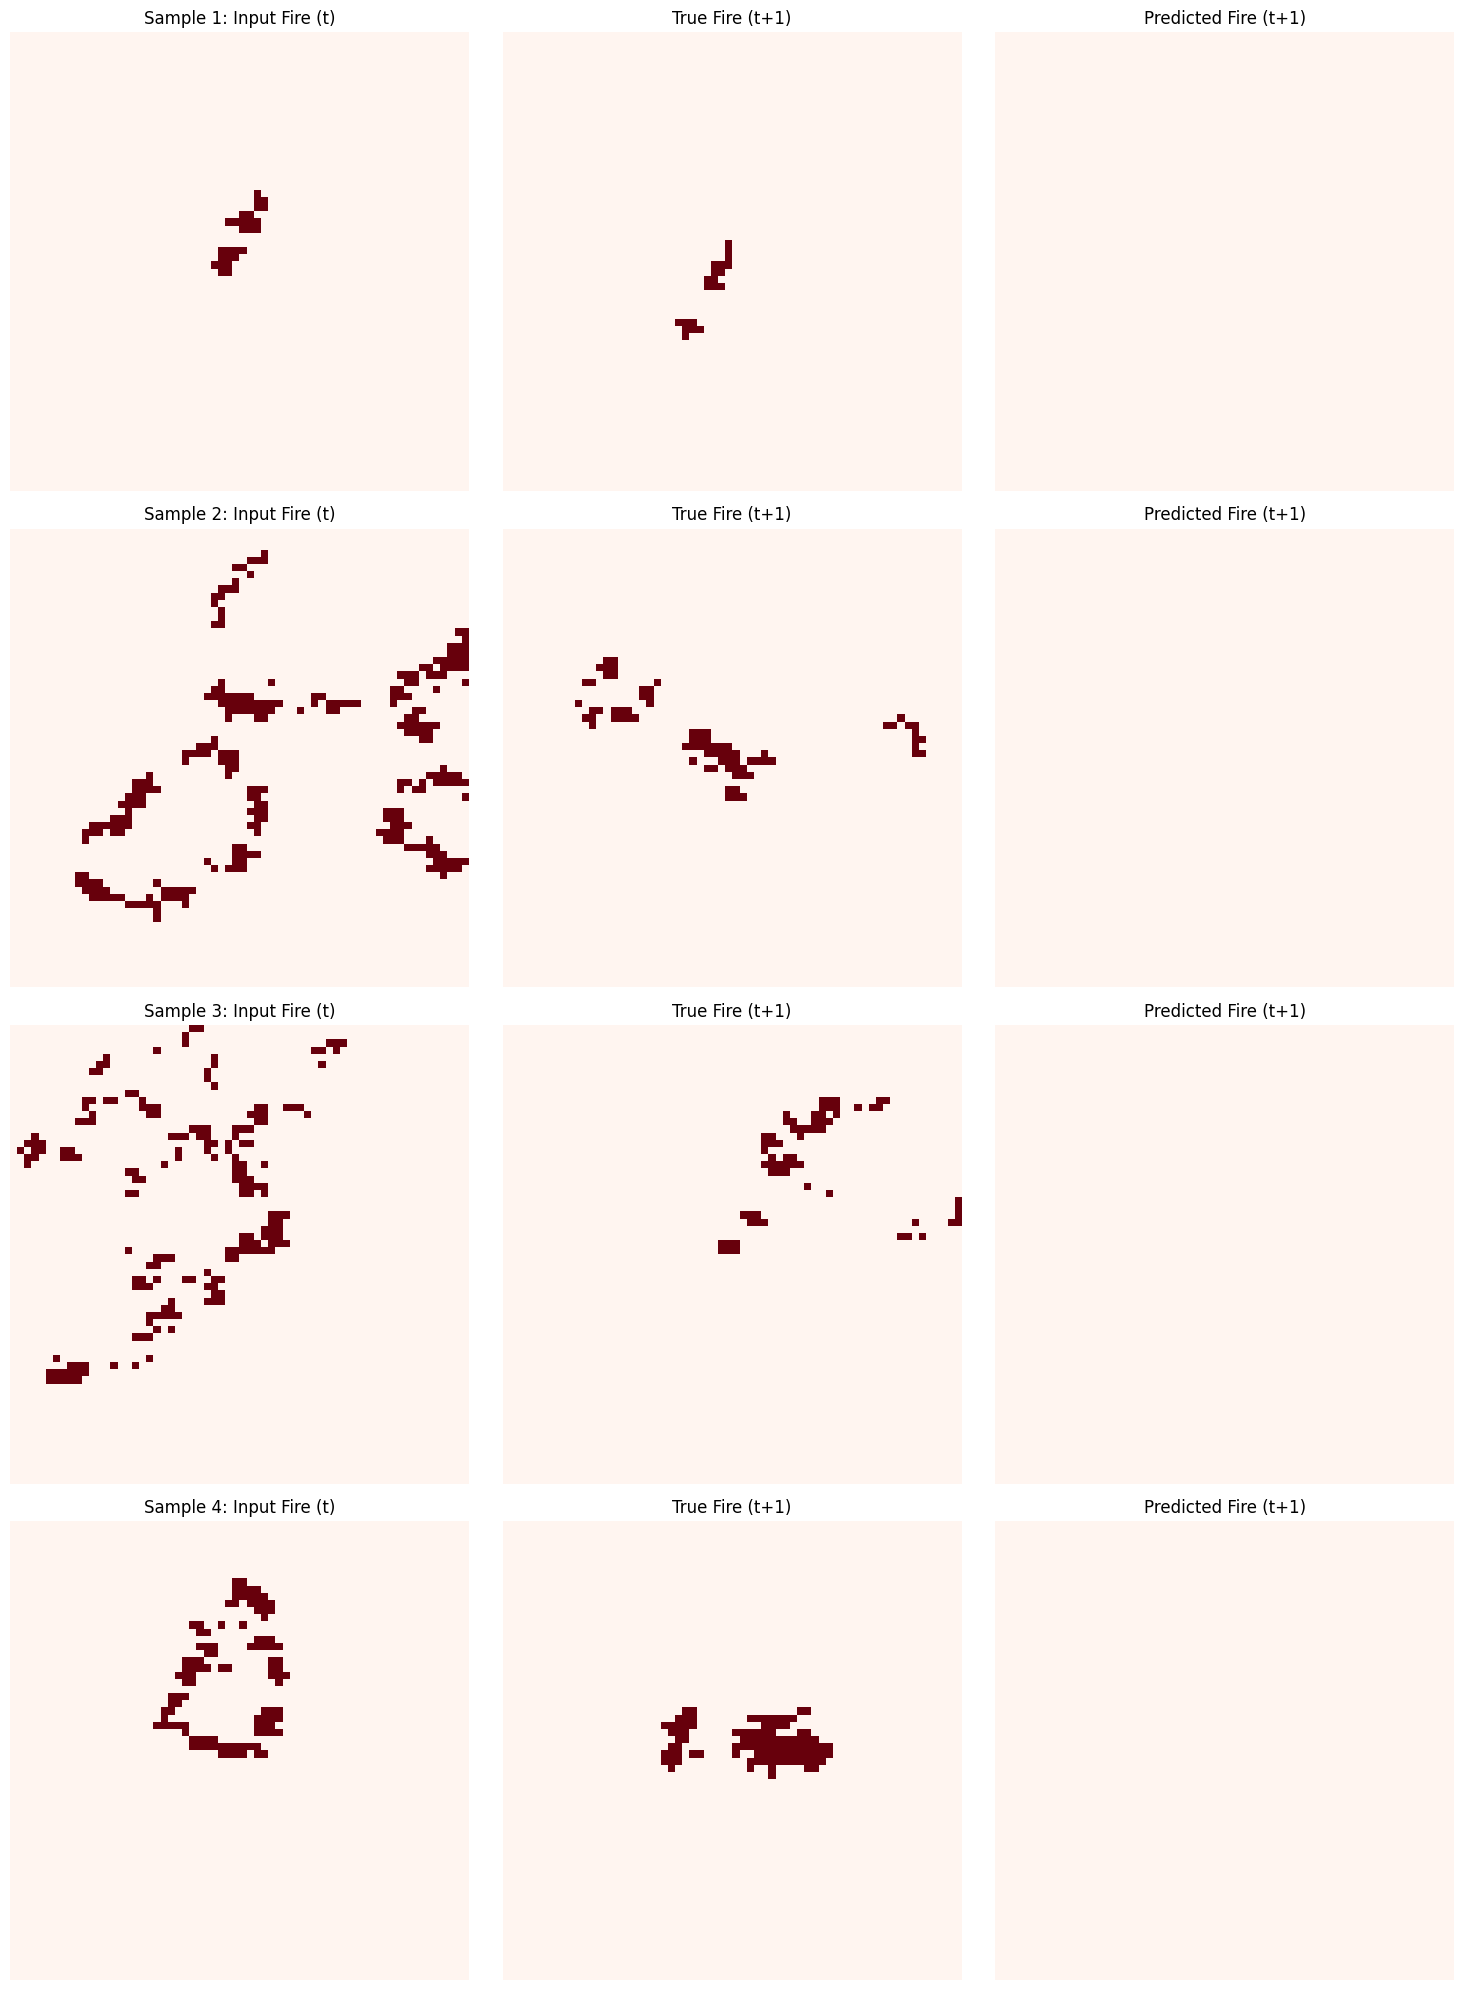


📊 PREDICTION STATISTICS:
🔥 True fire pixels in displayed samples: 266
🎯 Predicted fire pixels (threshold > 0.5): 0
📈 Average prediction confidence: 0.0000


In [5]:
# --- EXECUTION FOR COMBINED TIME-SERIES U-NET MODEL ---
model_name = "Combined_UNet"
checkpoint_file = "unet_checkpoint.pth"

# 1. Initialize the Dataset and Calculate Normalization
print("--- Step 1: Preparing Dataset ---")
# Create a dataset instance (can be large, as data isn't loaded yet)
temp_dataset = WildfireDataset(data_dir=DATA_DIR, num_timesteps=4, max_sequences=100)
# Calculate stats on a smaller, random subset for efficiency
normalization_stats = calculate_normalization_stats(temp_dataset, num_samples=100)

# Create the final dataset, now with normalization stats for on-the-fly processing
# max_sequences can be adjusted to limit the dataset size for faster experimentation
full_dataset = WildfireDataset(
    data_dir=DATA_DIR,
    num_timesteps=4,
    max_sequences=100, # Using 500 samples for a quicker run
    normalization_stats=normalization_stats
)

# 2. Train the U-Net model
final_model_unet = None
cv_results_unet = []

if len(full_dataset) > 0:
    print(f"\n--- Step 2: Training {model_name} ---")
    final_model_unet, cv_results_unet = train_fire_unet_cv_pytorch(
        full_dataset,
        n_splits=3,
        epochs=15,
        batch_size=4,
        checkpoint_path=checkpoint_file
    )
    if cv_results_unet:
        print(f"\n🎉 {model_name} TRAINING COMPLETED!")
    else:
        print(f"❌ {model_name} training failed or was interrupted!")
else:
    print(f"❌ Cannot train model - dataset is empty!")

# 3. Visualize the results
if final_model_unet is not None:
    print(f"\n--- Step 3: Generating Visualizations for {model_name} ---")
    
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    _, val_indices = list(kfold.split(full_dataset))[-1]

    num_viz_samples = min(4, len(val_indices))
    if num_viz_samples > 0:
        viz_inputs, viz_targets = [], []
        for i in range(num_viz_samples):
            # The dataset returns normalized inputs (C, H, W)
            x, y = full_dataset[val_indices[i]] 
            # We need to un-normalize the input fire mask for visualization
            means = normalization_stats['means'].numpy().transpose(1, 2, 0)
            stds = normalization_stats['stds'].numpy().transpose(1, 2, 0)
            x_unnorm = (x.numpy().transpose(1, 2, 0) * stds) + means
            
            viz_inputs.append(x_unnorm)
            viz_targets.append(np.transpose(y.numpy(), (1, 2, 0)))

        X_test_viz = np.array(viz_inputs)
        y_test_viz = np.array(viz_targets)

        # The visualization function expects UN-NORMALIZED data to show the original input fire mask
        visualize_fire_predictions_pytorch(
            final_model_unet, X_test_viz, y_test_viz, num_samples=num_viz_samples
        )
    else:
        print("Not enough validation samples to visualize.")
else:
    print(f"\n⚠️ {model_name} model not available for evaluation.")